### 第七课 VQA 视觉问答机器人

* 图灵测试

### 实战

这里我们用Keras来实现这么一个VQA的模型

你可以自由选择keras的backend，或者是theano或者是tensorflow

这个project涉及到大量图片，建议使用GPU。

本教程使用的是python3

#### 导入库

In [1]:
import sys
from random import shuffle
import argparse
 
import numpy as np
import scipy.io
 
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras.utils import np_utils, generic_utils
 
from sklearn import preprocessing
from sklearn.externals import joblib
 
import spacy
spacy.load('en_core_web_sm')
from spacy.lang.en import English

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


#### 下载并预处理素材

训练VQA，首先得需要一套用来训练的材料。

这里：http://www.visualqa.org/

给出了所有所需的素材，数据，等等。

所有的数据都是原始数据，所以我们需要做一点初始化，来把数据变成标准的结构，便于我们日后拿出来处理。

`preprocess.py` 这个方法就是用来一步到位预处理所有数据的：（相关原理和方法，在NLP基础课上讲过，这里不赘述）

通过这个方法，我们把所有问题/回答/对应图片给联系起来，用他们各自的“ID”代码来表示。

这样，我们只需要三个txt文档，就可以存下这么一个对应关系了。

data文件来源如：

* https://github.com/deepsidhpura777/Visual-Question-Answering-Using-CNN-LSTM-based-Stacked-Attention-Model

In [2]:
questions_train = open('/content/drive/My Drive/VQA/questions_train2014.txt', 'r').read().splitlines()
answers_train = open('/content/drive/My Drive/VQA/answers_train2014_modal.txt', 'r').read().splitlines()
images_train = open('/content/drive/My Drive/VQA/images_train2014.txt', 'r').read().splitlines()

### 对应回答的处理

根据课上讲解的内容，

我们把“看到一个图就能回答所有问题”这么一个看起来玄幻的目标，

简化成“从1000个最有可能的回答中，找到最符合图片的答案”这个样式。

也就是把一个开放AI问题，转化成了`multi-class`的分类问题。

好，我们来选取最popular的1000个问答：

In [3]:
import operator
from collections import defaultdict

In [4]:
max_answers = 1000# 设定最多选取多少个回答
answer_fq= defaultdict(int)
# 并为所有的问答，构造一个字典dict
for answer in answers_train:
    answer_fq[answer] += 1

In [5]:
# 按照出现次数，排序,选出前1000个出现频率最高的答案
sorted_fq = sorted(answer_fq.items(), key=operator.itemgetter(1), reverse=True)[0:max_answers]
top_answers, top_fq = zip(*sorted_fq)

In [6]:
new_answers_train=[]
new_questions_train=[]
new_images_train=[]
# 只提取top 1000问答相关
for answer,question,image in zip(answers_train, questions_train, images_train):
    if answer in top_answers:
        new_answers_train.append(answer)
        new_questions_train.append(question)
        new_images_train.append(image)
 
# 把新的数据赋值,这时候的数据由前1000个出现频率最高的答案所选出来
questions_train = new_questions_train
answers_train = new_answers_train
images_train = new_images_train

接下来，我们把所有的1000个答案给编号。

这样我们选取某个答案的时候，就不用使用“全称”，可以使用他们的label。

我们简单用到`sklearn`的`preprocessing`功能来赋值label。

当然，我们之后一直需要使用这个一一对应的label，所以我们存下来。

In [7]:
labelencoder = preprocessing.LabelEncoder()
labelencoder.fit(answers_train)
nb_classes = len(list(labelencoder.classes_))
joblib.dump(labelencoder,'/content/drive/My Drive/VQA/labelencoder.pkl')

['/content/drive/My Drive/VQA/labelencoder.pkl']

这个labelencoder怎么用？

我们写一个method，可以把所有的answers转化成数字化的label



In [9]:
def get_answers_matrix(answers, encoder):
    # string转化成数字化表达
    y = encoder.transform(answers) 
    nb_classes = encoder.classes_.shape[0]
    Y = np_utils.to_categorical(y, nb_classes)
    # 并构造成标准的matrix
    return Y

### input图片的处理

这里，我们使用工业/学术上都很耀眼的`VGG CNN`来提取图片的特征。

我们这里，直接运用已经成熟训练好的VGG CNN模型，直接下载，并导入，

因为我们用的是标准MSCOCO图片库，所以对应的标准VGG已经训练完备。

详见：http://mscoco.org/

http://cs.stanford.edu/people/karpathy/deepimagesent

用这个方法，我们把input图片的features一步到位地取出来。

文件地址：https://github.com/ZhenguoChen/Neural-Network-Image-Captioning

In [10]:
# 导入下载好的vgg_fearures (这是个matlab的文档，没关系，scipy可以读取)
vgg_model_path = '/content/drive/My Drive/VQA/vgg_feats.mat'

In [11]:
# 读入VGG features
features_struct = scipy.io.loadmat(vgg_model_path)
VGGfeatures = features_struct['feats']

In [12]:
# data source:https://raw.githubusercontent.com/architsharma97/VisualQA/4c6da4cb73936ffa271139dda215fd4cd261c495/Data/Coco/coco_vgg_IDMap.txt
# 跟图片一一对应
image_ids = open('/content/drive/My Drive/VQA/coco_vgg_IDMap.txt').read().splitlines()

In [13]:
id_map = {}
for ids in image_ids:
    id_split = ids.split()
    id_map[id_split[0]] = int(id_split[1])

这时候，我们再写一个method，

是用来取得任何一个input图片的“数字化表达形式”的，也就是一个matrix

这个matrix是由vgg扫过/处理图片以后，再加一层flatten得到的4096维的数组，我们称之为CNN Features

In [14]:
def get_images_matrix(img_coco_ids, img_map, VGGfeatures):
  nb_samples = len(img_coco_ids)
  nb_dimensions = VGGfeatures.shape[0]
  image_matrix = np.zeros((nb_samples, nb_dimensions))
  for j in range(len(img_coco_ids)):
    image_matrix[j,:] = VGGfeatures[:,img_map[img_coco_ids[j]]]
  return image_matrix

#### 提问问题的处理

接下来，是文字部分。

我们用SpaCy自带的英文模型。

把问句中的所有英文转化为vector，并平均化整个句子。

这个本质上就是我们NLP基础课上讲过的word2vec

In [15]:
nlp = English()# 载入Spacy的英语库
img_dim = 4096# 图片的维度大小
word_vec_dim = 300# 句子/单词的维度大小
 
# 这个method就是用来计算句子中所有word vector的总和，
# 目的在于把我们的文字用数字表示

def get_questions_matrix_sum(questions, nlp):
    # assert not isinstance(questions, basestring)
    nb_samples = len(questions)
    word_vec_dim = nlp(questions[0])[0].vector.shape[0]
    questions_matrix = np.zeros((nb_samples, word_vec_dim))
    for i in range(len(questions)):
        tokens = nlp(questions[i])
        for j in range(len(tokens)):
            questions_matrix[i,:] += tokens[j].vector
    return questions_matrix

#### VQA模型：MLP
我们来建立我们最简单版本的MLP模型

也就是普通的神经网络模型

注意：我这里就跑了1个epoch，只是为了Demo，真实场景中，这显然是不够的, 大家可以试试100次。



In [16]:
# 参数们
num_hidden_units = 1024
num_hidden_layers = 3
dropout = 0.5
activation = 'tanh'
# 注意：我这里就跑了1个epoch，
# 只是为了Demo，
# 真实场景中，
# 这显然是不够的
# 大家可以试试100次。
num_epochs = 1
model_save_interval = 10
batch_size = 128
 
# MLP之建造
# 输入层
model = Sequential()
model.add(Dense(num_hidden_units, input_dim=img_dim+word_vec_dim, kernel_initializer='uniform'))
model.add(Activation(activation))
model.add(Dropout(dropout))
# 中间层
for i in range(num_hidden_layers-1):
    model.add(Dense(num_hidden_units, kernel_initializer='uniform'))
    model.add(Activation(activation))
    model.add(Dropout(dropout))
# 输出层
model.add(Dense(nb_classes, kernel_initializer='uniform'))
model.add(Activation('softmax'))

如果以上的代码还不够清晰的话，
 
我们来吧构造的模型打印出来看看：


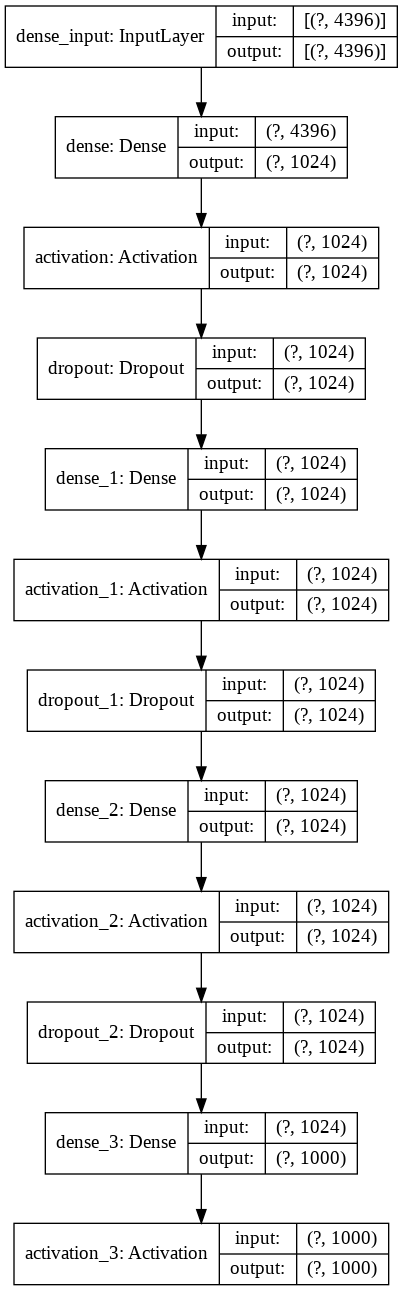

In [17]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='/content/drive/My Drive/VQA/model_mlp.png', show_shapes=True)
from IPython.display import Image
Image(filename='/content/drive/My Drive/VQA/model_mlp.png') 

好接下来，我们做一个保存的动作。

训练大规模网络的时候，这是一种比较保险的举措，即可以让我们回测数据，也可以在紧急情况下及时返回保存过了的模型

In [18]:
json_string = model.to_json()
model_file_name = '/content/drive/My Drive/VQA/mlp_num_hidden_units_' + str(num_hidden_units) + '_num_hidden_layers_' + str(num_hidden_layers)
open(model_file_name  + '.json', 'w').write(json_string)
# compile模型
model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

在训练之前，我们还需要一个chunk list的方法，来把我们原始的数据分成一组一组的形式

为了我们之后的batch training做准备

In [19]:
# 这是一个标准的chunk list方法
#  "grouper(3, 'abcdefg', 'x') --> ('a','b','c'), ('d','e','f'), ('g','x','x')"
from itertools import zip_longest
def grouper(iterable, n, fillvalue=None):
    args = [iter(iterable)] * n
    return zip_longest(*args, fillvalue=fillvalue)

可以开始训练了！

代码非常直观：

In [20]:
for k in range(num_epochs):
    # 给数据洗个牌先
    index_shuf = [i for i in range(len(questions_train))]
    shuffle(index_shuf)
    # 一一取出 问题，答案，和图片
    questions_train = [questions_train[i] for i in index_shuf]
    answers_train = [answers_train[i] for i in index_shuf]
    images_train = [images_train[i] for i in index_shuf]
    # 这就是个显示训练状态的bar，不写也没事，keras是默认有这个bar的
    # 但是如果你需要做一些customize的话，就可以在这个progbar上做文章
    progbar = generic_utils.Progbar(len(questions_train))
    # batch分组
    for qu_batch,an_batch,im_batch in zip(grouper(questions_train, batch_size, fillvalue=questions_train[-1]), 
                                        grouper(answers_train, batch_size, fillvalue=answers_train[-1]), 
                                        grouper(images_train, batch_size, fillvalue=images_train[-1])):
        X_q_batch = get_questions_matrix_sum(qu_batch, nlp)
        X_i_batch = get_images_matrix(im_batch, id_map, VGGfeatures)
        X_batch = np.hstack((X_q_batch, X_i_batch))
        Y_batch = get_answers_matrix(an_batch, labelencoder)
        loss = model.train_on_batch(X_batch, Y_batch)
        progbar.add(batch_size, values=[("train loss", loss)])
    # 并且告诉模型，隔多久，存一次模型，比如这里，model_save_interval是10
    if k % model_save_interval == 0:
        model.save_weights(model_file_name + '_epoch_{:02d}.hdf5'.format(k))
# 顺手把最终的模型也存下来
model.save_weights(model_file_name + '_epoch_{:02d}.hdf5'.format(k))

IndexError: ignored

这里注意，我们一共存了两种文件。

一种是json，是我们建立模型以后就存下来的东西，它代表了我们模型的龙骨（构架）

一种是hdf5, 全称Hierarchical Data Format，是非常高效的一种存储格式，把我们训练好的权重（weights）都记录下来。

那么，经过N轮的training之后，我们可以根据loss来监视效果。

那么，同学们如果想做一下Evaluation，或者模型升级，等等，都可以改改代码试试。

### 代码总结

In [ ]:
# 导入相关库
import sys
from random import shuffle
import argparse
import numpy as np
import scipy.io
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras.utils import np_utils, generic_utils
from sklearn import preprocessing
from sklearn.externals import joblib
from spacy.lang.en import English
import operator
from collections import defaultdict
# 打印模型
from keras.utils.vis_utils import plot_model
from IPython.display import Image
from itertools import zip_longest
 
"""  读取数据  """
questions_train = open('data/questions_train2014.txt', 'r').read().splitlines()
answers_train = open('data/answers_train2014_modal.txt','r').read().splitlines()
images_train = open('data/images_train2014.txt','r').read().splitlines()
 
""" 对应回答的处理  """
 
# 设定最多选取多少个回答
max_answers = 1000
answer_fq= defaultdict(int)
# 并为所有的问答，构造一个字典dict
for answer in answers_train:
    answer_fq[answer] += 1
# 按照出现次数，排序
sorted_fq = sorted(answer_fq.items(), key=operator.itemgetter(1), reverse=True)[0:max_answers]
top_answers, top_fq = zip(*sorted_fq)
new_answers_train=[]
new_questions_train=[]
new_images_train=[]
# 只提取top 1000问答相关
for answer,question,image in zip(answers_train, questions_train, images_train):
    if answer in top_answers:
        new_answers_train.append(answer)
        new_questions_train.append(question)
        new_images_train.append(image)
 
# 把新的数据赋值
questions_train = new_questions_train
answers_train = new_answers_train
images_train = new_images_train
 
# 接下来，我们把所有的1000个答案给编号 简单用到sklearn的preprocessing功能来赋值label
 
labelencoder = preprocessing.LabelEncoder()
labelencoder.fit(answers_train)
nb_classes = len(list(labelencoder.classes_))
joblib.dump(labelencoder,'data/labelencoder.pkl')
# print(labelencoder.classes_)    # [...'yes' 'young' 'zebra' 'zebras' 'zoo']
# print(labelencoder.transform(['yes']))  # [[... 1 0 0 0 0]]
 
 
""" 我们写一个method，可以把所有的answers转化成数字化的label """
 
 
def get_answers_matrix(answers, encoder):
    # string转化成数字化表达
    y = encoder.transform(answers)
    nb_classes = encoder.classes_.shape[0]
    Y = np_utils.to_categorical(y, nb_classes)
    # 并构造成标准的matrix
    return Y
 
# 我们把input图片的features一步到位地取出来
vgg_model_path = 'mscoco/vgg_feats.mat'
 
# 读入VGG features
features_struct = scipy.io.loadmat(vgg_model_path)
VGGfeatures = features_struct['feats']
# 跟图片一一对应
image_ids = open('data/coco_vgg_IDMap.txt').read().splitlines()
id_map = {}
for ids in image_ids:
    id_split = ids.split()
    id_map[id_split[0]] = int(id_split[1])
 
 
"""
是用来取得任何一个input图片的“数字化表达形式”的，也就是一个matrix
这个matrix是由vgg扫过/处理图片以后，再加一层flatten得到的4096维的数组，
我们称之为CNN Features
"""
def get_images_matrix(img_coco_ids, img_map, VGGfeatures):
    nb_samples = len(img_coco_ids)
    nb_dimensions = VGGfeatures.shape[0]
    image_matrix = np.zeros((nb_samples, nb_dimensions))
    for j in range(len(img_coco_ids)):
        image_matrix[j,:] = VGGfeatures[:,img_map[img_coco_ids[j]]]
    return image_matrix
 
"""
提问问题的处理
接下来，是文字部分。
我们用SpaCy自带的英文模型。把问句中的所有英文转化为vector，并平均化整个句子。
这个本质上就是我们NLP基础课上讲过的word2vec
"""
 
# 载入Spacy的英语库
nlp = English()
# 图片的维度大小
img_dim = 3796
# 句子/单词的维度大小
word_vec_dim = 300
 
# 这个method就是用来计算句子中所有word vector的总和，
# 目的在于把我们的文字用数字表示
def get_questions_matrix_sum(questions, nlp):
    # assert not isinstance(questions, basestring)
    nb_samples = len(questions)
    word_vec_dim = nlp(questions[0])[0].vector.shape[0]
    questions_matrix = np.zeros((nb_samples, word_vec_dim))
    for i in range(len(questions)):
        tokens = nlp(questions[i])
        for j in range(len(tokens)):
            questions_matrix[i,:] += tokens[j].vector
    return questions_matrix
 
# VQA模型：MLP
# 参数们
num_hidden_units = 1024
num_hidden_layers = 3
dropout = 0.5
activation = 'tanh'
# 注意：我这里就跑了1个epoch，
# 只是为了Demo，
# 真实场景中，
# 这显然是不够的
# 大家可以试试100次。
num_epochs = 1
model_save_interval = 10
batch_size = 128
 
# MLP之建造
# 输入层
model = Sequential()
model.add(Dense(num_hidden_units, input_dim=img_dim+word_vec_dim, kernel_initializer='uniform'))
model.add(Activation(activation))
model.add(Dropout(dropout))
# 中间层
for i in range(num_hidden_layers-1):
    model.add(Dense(num_hidden_units, kernel_initializer='uniform'))
    model.add(Activation(activation))
    model.add(Dropout(dropout))
# 输出层
model.add(Dense(nb_classes, kernel_initializer='uniform'))
model.add(Activation('softmax'))
 
# 打印模型 -- windows 麻烦是多干脆不打印了
# plot_model(model, to_file='data/model_mlp.peng', show_shapes=True)
# Image(filename='data/model_mlp.peng')
 
# 好接下来，我们做一个保存的动作
json_string = model.to_json()
model_file_name = 'data/mlp_num_hidden_units_' + str(num_hidden_units) + '_num_hidden_layers_' + str(num_hidden_layers)
open(model_file_name  + '.json', 'w').write(json_string)
# compile模型
model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
 
 
# 在训练之前，我们还需要一个chunk list的方法，来把我们原始的数据分成一组一组的形式
# 为了我们之后的batch training做准备
# 这是一个标准的chunk list方法
#  "grouper(3, 'abcdefg', 'x') --> ('a','b','c'), ('d','e','f'), ('g','x','x')"
 
def grouper(iterable, n, fillvalue=None):
    args = [iter(iterable)] * n
    return zip_longest(*args, fillvalue=fillvalue)
 
# 开始训练
for k in range(num_epochs):
    # 给数据洗个牌先
    index_shuf = [i for i in range(len(questions_train))]
    shuffle(index_shuf)
    # 一一取出 问题，答案，和图片
    questions_train = [questions_train[i] for i in index_shuf]
    answers_train = [answers_train[i] for i in index_shuf]
    images_train = [images_train[i] for i in index_shuf]
    # 这就是个显示训练状态的bar，不写也没事，keras是默认有这个bar的
    # 但是如果你需要做一些customize的话，就可以在这个progbar上做文章
    progbar = generic_utils.Progbar(len(questions_train))
    # batch分组
    for qu_batch,an_batch,im_batch in zip(grouper(questions_train, batch_size, fillvalue=questions_train[-1]),
                                        grouper(answers_train, batch_size, fillvalue=answers_train[-1]),
                                        grouper(images_train, batch_size, fillvalue=images_train[-1])):
        X_q_batch = get_questions_matrix_sum(qu_batch, nlp)
        X_i_batch = get_images_matrix(im_batch, id_map, VGGfeatures)
        X_batch = np.hstack((X_q_batch, X_i_batch))
        Y_batch = get_answers_matrix(an_batch, labelencoder)
        loss = model.train_on_batch(X_batch, Y_batch)
        progbar.add(batch_size, values=[("train loss", loss)])
    # 并且告诉模型，隔多久，存一次模型，比如这里，model_save_interval是10
    if k%model_save_interval == 0:
        model.save_weights(model_file_name + '_epoch_{:02d}.hdf5'.format(k))
# 顺手把最终的模型也存下来
model.save_weights(model_file_name + '_epoch_{:02d}.hdf5'.format(k))

### 第三章 
道理上讲，这里训练的部分，跟前面依旧没啥区别，

唯一的区别是，我们造语言部分的matrix的时候，使用timestep的方法，也就是我们刚刚上面改写的那个方法



### 参考文献
* https://blog.csdn.net/m0_37156901/article/details/94997517#t0